## Use pre-trained models to make predictions on normal tissue samples

For some cancer types, TCGA provides samples from normal tissue in addition to the tumor samples (see `01_explore_data/normal_tissue_samples.ipynb`).

In this analysis, we want to make predictions on those samples and compare them to our tumor sample predictions.

Our assumption is that our models will predict that the normal tissue samples have a low probability of mutation (since they almost certainly do not have somatic mutations in any of the genes of interest).

In [1]:
from pathlib import Path
import pickle as pkl

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au
import mpmp.utilities.data_utilities as du
import mpmp.utilities.plot_utilities as plu
import mpmp.utilities.tcga_utilities as tu

%load_ext autoreload
%autoreload 2

In [2]:
results_dir = Path(cfg.results_dirs['final'],
                   'pilot_genes',
                   'gene').resolve()

genes = [g.stem for g in results_dir.iterdir() if not g.is_file()]
print(genes)

['TP53', 'EGFR', 'IDH1', 'PIK3CA', 'SETD2', 'KRAS']


### Load pre-trained model

In [3]:
gene = 'SETD2'
training_data = 'expression'

model_filename = '{}_{}_elasticnet_classify_s42_model.pkl'.format(gene, training_data)

with open(str(results_dir / gene / model_filename), 'rb') as f:
    model_fit = pkl.load(f)

print(model_fit)
print(model_fit.feature_names_in_.shape)

SGDClassifier(alpha=1.0, class_weight='balanced', l1_ratio=0.05, loss='log',
              penalty='elasticnet', random_state=42)
(15374,)


### Load expression data and sample info

In [4]:
# load expression sample info, this has tumor/normal labels
sample_info_df = du.load_sample_info(training_data)
print(sample_info_df.sample_type.unique())
sample_info_df.head()

['Primary Solid Tumor' 'Recurrent Solid Tumor' 'Solid Tissue Normal'
 'Additional - New Primary' 'Metastatic'
 'Primary Blood Derived Cancer - Peripheral Blood' 'Additional Metastatic']


,sample_type,cancer_type,id_for_stratification
sample_id,,,
TCGA-02-0047-01,Primary Solid Tumor,GBM,GBMPrimary Solid Tumor
TCGA-02-0055-01,Primary Solid Tumor,GBM,GBMPrimary Solid Tumor
TCGA-02-2483-01,Primary Solid Tumor,GBM,GBMPrimary Solid Tumor
TCGA-02-2485-01,Primary Solid Tumor,GBM,GBMPrimary Solid Tumor
TCGA-02-2486-01,Primary Solid Tumor,GBM,GBMPrimary Solid Tumor


In [5]:
# load expression data
data_df = du.load_raw_data('expression', verbose=True)
print(data_df.shape)
data_df.iloc[:5, :5]

Loading expression data...


(11060, 15369)


,1,100,1000,10000,10001
sample_id,,,,,
TCGA-02-0047-01,125.0,136.0,2300.0,1300.0,272.0
TCGA-02-0055-01,392.0,222.0,1820.0,903.0,321.0
TCGA-02-2483-01,272.0,256.0,2890.0,1320.0,458.0
TCGA-02-2485-01,83.9,129.0,6970.0,10100.0,419.0
TCGA-02-2486-01,108.0,205.0,2250.0,873.0,441.0


In [6]:
# load mutation data
pancancer_data = du.load_pancancer_data()
(sample_freeze_df,
 mutation_df,
 copy_loss_df,
 copy_gain_df,
 mut_burden_df) = pancancer_data

### Subset expression data to get train and control samples

We want to compare predictions made using the trained model on the control samples to predictions on the (tumor-derived) data used to train the model, so we'll load both expression datasets here.

In [7]:
# get cancer types that were used to train the model
valid_cancer_types = sample_info_df.cancer_type.unique()
train_cancer_types = [
    f for f in model_fit.feature_names_in_ if f in valid_cancer_types
]
print(train_cancer_types)

['BLCA', 'KIRC', 'KIRP', 'LUAD']


In [8]:
# get samples that were used to train the model
train_samples = (
    sample_info_df[sample_info_df.cancer_type.isin(train_cancer_types)]
      .index
      .intersection(data_df.index)
      .intersection(mut_burden_df.index)
)
train_data_df = data_df.loc[train_samples, :]
print(train_data_df.shape)
train_data_df.iloc[:5, :5]

(1523, 15369)


,1,100,1000,10000,10001
TCGA-05-4244-01,26.0,150.0,4.19,948.0,412.0
TCGA-05-4249-01,120.0,73.1,7.73,174.0,349.0
TCGA-05-4250-01,50.9,266.0,79.90,760.0,651.0
TCGA-05-4382-01,146.0,288.0,82.60,477.0,475.0
TCGA-05-4384-01,127.0,75.1,11.00,305.0,411.0


In [9]:
# get normal samples that we have expression data for
normal_ids = (
    sample_info_df[sample_info_df.sample_type.str.contains('Normal')]
      .index
      .intersection(data_df.index)
)
print(len(normal_ids))
print(normal_ids[:5])

737
Index(['TCGA-06-0675-11', 'TCGA-06-0678-11', 'TCGA-06-0680-11',
       'TCGA-06-0681-11', 'TCGA-06-AABW-11'],
      dtype='object', name='sample_id')


In [10]:
# get normal expression data
normal_data_df = data_df.loc[normal_ids, :]
print(normal_data_df.shape)
normal_data_df.iloc[:5, :5]

(737, 15369)


,1,100,1000,10000,10001
sample_id,,,,,
TCGA-06-0675-11,88.5,43.6,2090.0,3250.0,312.0
TCGA-06-0678-11,58.5,101.0,2060.0,2490.0,317.0
TCGA-06-0680-11,80.8,53.7,2170.0,3090.0,291.0
TCGA-06-0681-11,141.0,148.0,1910.0,2210.0,311.0
TCGA-06-AABW-11,258.0,208.0,1560.0,786.0,251.0


### Add covariates for train/normal samples

This is a bit nuanced since we don't have mutation calling information for the normal samples, so we can't generate a log(mutation burden) covariate.

For now we'll just take the mean mutation burden from the tumor dataset and apply it to all the normal samples.

In [11]:
print(mut_burden_df.shape)
mut_burden_df.head()

(9074, 1)


,log10_mut
SAMPLE_BARCODE,
TCGA-02-0047-01,1.812913
TCGA-02-0055-01,1.707570
TCGA-02-2483-01,1.662758
TCGA-02-2485-01,1.748188
TCGA-02-2486-01,1.755875


In [12]:
# construct covariate matrix for train samples
train_info_df = (
    mut_burden_df.loc[train_samples, :]
      .merge(sample_info_df, left_index=True, right_index=True)    
      .drop(columns={'id_for_stratification'})
      .rename(columns={'cancer_type': 'DISEASE'})
)
print(train_info_df.shape)
train_info_df.head()

(1523, 3)


,log10_mut,sample_type,DISEASE
TCGA-05-4244-01,2.285557,Primary Solid Tumor,LUAD
TCGA-05-4249-01,2.488551,Primary Solid Tumor,LUAD
TCGA-05-4250-01,2.502427,Primary Solid Tumor,LUAD
TCGA-05-4382-01,3.193125,Primary Solid Tumor,LUAD
TCGA-05-4384-01,2.089905,Primary Solid Tumor,LUAD


In [13]:
mean_mutation_burden = mut_burden_df.sum() / mut_burden_df.shape[0]
print(mean_mutation_burden)

log10_mut    1.834867
dtype: float64


In [14]:
# construct covariate matrix for normal samples
normal_info_df = pd.DataFrame(
    {'log10_mut': mean_mutation_burden.values[0]},
    index=normal_ids
)
# add cancer type info for normal samples
normal_info_df = (normal_info_df
    .merge(sample_info_df, left_index=True, right_index=True)    
    .drop(columns={'id_for_stratification'})
    .rename(columns={'cancer_type': 'DISEASE'})
)
print(normal_info_df.shape)
normal_info_df.head()

(737, 3)


,log10_mut,sample_type,DISEASE
sample_id,,,
TCGA-06-0675-11,1.834867,Solid Tissue Normal,GBM
TCGA-06-0678-11,1.834867,Solid Tissue Normal,GBM
TCGA-06-0680-11,1.834867,Solid Tissue Normal,GBM
TCGA-06-0681-11,1.834867,Solid Tissue Normal,GBM
TCGA-06-AABW-11,1.834867,Solid Tissue Normal,GBM


In [15]:
def add_dummies_from_model(data_df, info_df, model):
    """TODO: document what info_df looks like, etc"""
    # get cancer type covariates used in original model,
    # in the correct order
    cov_matrix = np.zeros((info_df.shape[0], len(train_cancer_types)))
    for sample_ix, (_, row) in enumerate(info_df.iterrows()):
        try:
            row_cancer_type = row.DISEASE
            cov_ix = train_cancer_types.index(row_cancer_type)
            cov_matrix[sample_ix, cov_ix] = 1
        except ValueError:
            # if cancer type is not in train set (e.g. for a normal sample),
            # just leave it an all-zeros row
            continue
    mut_burden = info_df.log10_mut.values.reshape(-1, 1)
    feature_matrix = np.concatenate(
        (data_df, mut_burden, cov_matrix),
        axis=1
    )
    X_df = pd.DataFrame(
        feature_matrix,
        index=data_df.index.copy(),
        columns=model.feature_names_in_[:]
    )
    return X_df

In [16]:
X_train_df = add_dummies_from_model(train_data_df,
                                    train_info_df,
                                    model_fit)

In [17]:
X_normal_df = add_dummies_from_model(normal_data_df,
                                     normal_info_df,
                                     model_fit)
print(X_normal_df.shape)
X_normal_df.iloc[:5, -20:]

(737, 15374)


,998,9980,9984,9985,9986,9987,9988,9989,999,9990,9991,9992,9993,9994,9997,log10_mut,BLCA,KIRC,KIRP,LUAD
sample_id,,,,,,,,,,,,,,,,,,,,
TCGA-06-0675-11,3650.0,829.0,175.0,386.0,120.0,4990.0,769.0,653.0,51.7,1150.0,623.0,13.90,5230.0,288.0,393.0,1.834867,0.0,0.0,0.0,0.0
TCGA-06-0678-11,4120.0,778.0,226.0,183.0,141.0,5040.0,854.0,728.0,104.0,1100.0,626.0,7.46,3530.0,257.0,410.0,1.834867,0.0,0.0,0.0,0.0
TCGA-06-0680-11,3590.0,898.0,229.0,333.0,118.0,4770.0,901.0,616.0,50.5,1290.0,584.0,13.40,4520.0,284.0,389.0,1.834867,0.0,0.0,0.0,0.0
TCGA-06-0681-11,3850.0,632.0,294.0,374.0,174.0,5150.0,838.0,646.0,97.9,1070.0,551.0,12.00,5300.0,223.0,526.0,1.834867,0.0,0.0,0.0,0.0
TCGA-06-AABW-11,5230.0,366.0,441.0,425.0,184.0,6640.0,1200.0,857.0,607.0,1400.0,338.0,9.05,4570.0,320.0,285.0,1.834867,0.0,0.0,0.0,0.0


### Preprocessing for train/normal samples

We want to do the following for preprocessing:

* Make sure we're using the same set of gene features that the model was trained on (or subset to those gene features if not)
* Standardize the train/normal samples (we'll do this for each dataset independently, for now)

In [18]:
non_gene_features = list(valid_cancer_types) + ['log10_mut']
train_gene_features = [
    f for f in model_fit.feature_names_in_ if f not in non_gene_features
]
print(train_gene_features[:5])
print(train_gene_features[-5:])

['1', '100', '1000', '10000', '10001']
['9991', '9992', '9993', '9994', '9997']


In [19]:
# we don't want to standardize the non-gene features
is_gene_feature = np.array(
    [(f in train_gene_features) for f in model_fit.feature_names_in_]
)
print(is_gene_feature[:5])
print(is_gene_feature[-5:])
print(sum(is_gene_feature))

[ True  True  True  True  True]
[False False False False False]
15369


In [20]:
X_train_std_df = tu.standardize_features(X_train_df, is_gene_feature)
X_train_std_df.iloc[:5, :5]

,1,100,1000,10000,10001
TCGA-05-4244-01,-0.282278,-0.321493,-0.761408,0.390861,0.364897
TCGA-05-4249-01,0.057032,-0.593912,-0.758731,-0.812048,-0.051142
TCGA-05-4250-01,-0.192397,0.089439,-0.704154,0.098681,1.943205
TCGA-05-4382-01,0.150884,0.167374,-0.702113,-0.341142,0.780936
TCGA-05-4384-01,0.082300,-0.586827,-0.756258,-0.608455,0.358293


In [21]:
X_normal_std_df = tu.standardize_features(X_normal_df, is_gene_feature)
X_normal_std_df.iloc[:5, :5]

,1,100,1000,10000,10001
sample_id,,,,,
TCGA-06-0675-11,-0.282489,-0.225114,1.746405,3.626160,-0.019419
TCGA-06-0678-11,-0.283591,-0.124853,1.712948,2.419237,0.040312
TCGA-06-0680-11,-0.282772,-0.207472,1.835622,3.372071,-0.270289
TCGA-06-0681-11,-0.280561,-0.042758,1.545664,1.974581,-0.031365
TCGA-06-AABW-11,-0.276264,0.062043,1.155336,-0.286811,-0.748137


### Make predictions and visualize results

In [22]:
y_train_preds = model_fit.predict_proba(X_train_std_df)[:, 1]
y_normal_preds = model_fit.predict_proba(X_normal_std_df)[:, 1]

print(y_train_preds.shape)
print(y_normal_preds.shape)

(1523,)
(737,)


In [23]:
def get_mutations_for_gene(gene, classification, samples):
    # get classification
    # build labels
    classification = du.get_classification(gene)
    print(gene, classification)
    gene_mutation_df = mutation_df.loc[:, gene]
    if classification == "Oncogene":
        copy_number_df = copy_gain_df.loc[:, gene]
    elif classification == "TSG":
        copy_number_df = copy_loss_df.loc[:, gene]
    elif classification == "Oncogene, TSG":
        # some genes may act as both (i.e. in a cancer type-specific
        # or tissue-specific manner), in this case we'll just use the
        # union of the gain/loss dfs to define positive labeled samples
        copy_number_df = (
            copy_gain_df.loc[:, gene] | copy_loss_df.loc[:, gene]
        )
    else:
        copy_number_df = pd.DataFrame()
        include_copy = False
    # subset and return
    y_df = copy_number_df + gene_mutation_df
    return y_df.reindex(samples)
    
y_train_labels = get_mutations_for_gene(gene, 'Oncogene', X_train_std_df.index)
y_train_labels.head()

SETD2 TSG


TCGA-05-4244-01    0
TCGA-05-4249-01    0
TCGA-05-4250-01    0
TCGA-05-4382-01    0
TCGA-05-4384-01    0
Name: SETD2, dtype: int64

In [24]:
def get_name(ix):
    if y_train_labels[ix] == 1:
        return 'tumor, mutated'
    else:
        return 'tumor, not mutated'
    
train_names = [get_name(ix) for ix in X_train_std_df.index]
plot_df = pd.DataFrame(
    {'pred': np.concatenate((y_train_preds, y_normal_preds)),
     'dataset': (train_names) + (['normal'] * y_normal_preds.shape[0])}
)
plot_df.head()

,pred,dataset
0,0.371177,"tumor, not mutated"
1,0.268242,"tumor, not mutated"
2,0.387161,"tumor, not mutated"
3,0.334640,"tumor, not mutated"
4,0.208178,"tumor, not mutated"


Text(0, 0.5, 'Predicted mutation probability')

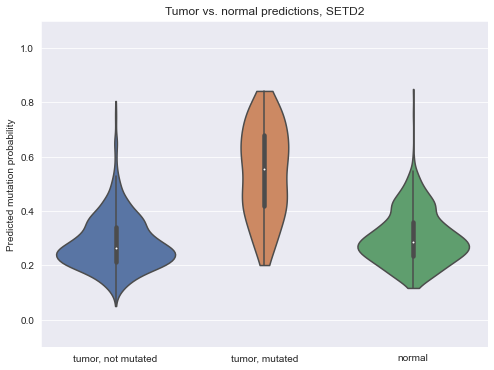

In [25]:
sns.set({'figure.figsize': (8, 6)})

sns.violinplot(data=plot_df, x='dataset', y='pred', cut=0)
plt.title('Tumor vs. normal predictions, {}'.format(gene))
plt.ylim((-0.1, 1.1))
plt.xlabel('')
plt.ylabel('Predicted mutation probability')